In [2]:
import mysql.connector as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.cluster import KMeans
from kneed import KneeLocator

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)


### Import Dataset dari Local Database

In [4]:
db_connection = sql.connect(host='localhost', database='finalprojectrakamin', user='root', password='',port=3306, auth_plugin='mysql_native_password')

df = pd.read_sql(""" 
        SELECT a.`Date`, a.`TransactionID`, a.`CustomerID`, a.`ProductID`, a.`StoreID`, a.`Qty`, a.`TotalAmount`, 
        b.`StoreName`, b.`GroupStore`, b.`Type`, b.`Latitude`, b.`Longitude`, 
        c.`Age`, c.`Gender`, c.`Marital Status`, c.`Income`, 
        d.`Product Name`, d.`Price`
        FROM transaction a
        INNER JOIN store b ON a.StoreID = b.StoreID
        INNER JOIN customer c ON a.CustomerID = c.CustomerID
        INNER JOIN product d ON a.ProductID = d.ProductID
        ORDER BY 1, 2, 3, 4, 5
        """, con=db_connection)

df.head()

,Date,TransactionID,CustomerID,ProductID,StoreID,Qty,TotalAmount,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income,Product Name,Price
0,01/01/2022,TR11369,328,P3,12,4,30000,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,Married,"10,53",Crackers,7500
1,01/01/2022,TR16356,165,P9,1,7,70000,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,Married,"14,58",Yoghurt,10000
2,01/01/2022,TR1984,183,P1,4,4,35200,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,Single,"0,18",Choco Bar,8800
3,01/01/2022,TR35256,160,P1,4,7,61600,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,Married,"12,57",Choco Bar,8800
4,01/01/2022,TR41231,386,P9,4,1,10000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,Married,"6,95",Yoghurt,10000


<b>Customer</b>
- CustomerID : No Unik Customer
- Age : Usia Customer
- Gender : 0 Wanita, 1 Pria
- Marital Status : Married, Single (Blm menikah/Pernah menikah)
- Income : Pendapatan per bulan dalam jutaan rupiah
<br><br>

<b>Store</b>
- StoreID : Kode Unik Store
- StoreName : Nama Toko
- GroupStore : Nama group
- Type : Modern Trade, General Trade
- Latitude : Kode Latitude
- Longitude : Kode Longitude
<br><br>

<b>Product</b>
- ProductID : Kode Unik Product
- Product Name : Nama Product
- Price : Harga dlm rupiah
<br><br>

<b>Transaction</b>
- TransactionID : Kode Unik Transaksi
- Date : Tanggal transaksi
- Qty : Jumlah item yang dibeli
- Total Amount : Price x Qty

### Exploratory Data Analysis

<b>Mengubah koma menjadi titik pada kolom Latitude, Longitude, dan Income</b>

In [100]:
df[['Latitude', 'Longitude', 'Income']] = df[['Latitude', 'Longitude', 'Income']].replace(',', '.', regex=True)
df[['Latitude', 'Longitude', 'Income']].head()

,Latitude,Longitude,Income
0,-2.990934,104.756554,10.53
1,-6.2,106.816666,14.58
2,-6.966667,110.416664,0.18
3,-6.966667,110.416664,12.57
4,-6.966667,110.416664,6.95


<b>Melihat jumlah baris dan kolom, nilai kosong, dan data duplikat pada Dataset</b>

In [101]:
print(f"Dataset terdiri dari {df.shape[0]} baris dan {df.shape[1]} kolom")
print(f"Dataset memiliki {df['Marital Status'].isnull().sum().sum()} nilai kosong")
print(f"Dataset memiliki {df.duplicated().sum()} data duplikat")

Dataset terdiri dari 4976 baris dan 18 kolom
Dataset memiliki 0 nilai kosong
Dataset memiliki 0 data duplikat


<b>Melihat tipe data pada setiap kolom</b>

In [102]:
df.dtypes

Date              object
TransactionID     object
CustomerID         int64
ProductID         object
StoreID            int64
Qty                int64
TotalAmount        int64
StoreName         object
GroupStore        object
Type              object
Latitude          object
Longitude         object
Age                int64
Gender             int64
Marital Status    object
Income            object
Product Name      object
Price              int64
dtype: object

<b>Memperbaiki tipe data</b><br>
Kolom Date, CustomerID, StoreID, Latitude, Longitude, dan Income

In [103]:
df['Date'] = pd.to_datetime(df['Date'])
df['CustomerID'] = df['CustomerID'].astype('object')
df['StoreID'] = df['StoreID'].astype('object')
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')
df['Income'] = df['Income'].astype('float')
df['Marital Status'] = df['Marital Status'].astype('category')
df['Gender'] = df['Gender'].astype('bool')

df.dtypes

Date              datetime64[ns]
TransactionID             object
CustomerID                object
ProductID                 object
StoreID                   object
Qty                        int64
TotalAmount                int64
StoreName                 object
GroupStore                object
Type                      object
Latitude                 float64
Longitude                float64
Age                        int64
Gender                      bool
Marital Status          category
Income                   float64
Product Name              object
Price                      int64
dtype: object

<b>Melihat statistik deskriptif dari data numerik dan kategorik</b>

In [104]:
numerik = df.select_dtypes(include=['int64', 'float64']).columns
kategorik = df.select_dtypes(include=['object', 'bool', 'category']).columns

df[numerik].describe()

,Qty,TotalAmount,Latitude,Longitude,Age,Income,Price
count,4976.000,4976.000,4976.000,4976.000,4976.000,4976.000,4976.000
mean,3.642,32268.629,-2.944,109.602,40.080,8.649,9690.293
std,1.856,19661.513,4.321,8.369,12.863,6.536,4601.845
min,1.000,7500.000,-7.797,95.324,0.000,0.000,3200.000
25%,2.000,16000.000,-6.915,104.757,30.000,4.250,4200.000
50%,3.000,28200.000,-5.135,110.371,39.000,7.720,9400.000
75%,5.000,47000.000,0.534,114.590,51.000,10.840,15000.000
max,10.000,88000.000,5.548,128.191,72.000,71.300,18000.000


In [105]:
df[kategorik].describe()

,TransactionID,CustomerID,ProductID,StoreID,StoreName,GroupStore,Type,Gender,Marital Status,Product Name
count,4976,4976,4976,4976,4976,4976,4976,4976,4976,4976
unique,4866,444,10,14,12,7,2,2,2,10
top,TR71313,156,P5,9,Lingga,Prima,General Trade,False,Married,Thai Tea
freq,3,21,803,370,734,1074,2823,2746,3779,803


<b>Menyimpan data yang sudah dibersihkan</b>

In [106]:
df.to_csv('data_time_series.csv', index=False)

### Preprocessing

<b>Preprocessing data dengan mengambil data yang dibutuhkan berdasarkan CustomerID</b>

In [107]:
df_clustering = df.groupby('CustomerID').agg({'TransactionID': 'count', 'Qty': 'sum', 'TotalAmount': 'sum', 'Gender': 'first', 'Marital Status': 'first', 'Income': 'first', 'Age': 'first'}).rename(columns={'TransactionID': 'NumberOfTransaction'})

df_clustering['Gender'] = df_clustering['Gender'].replace({True: 'Laki-Laki', False: 'Wanita'})

data_clustering = df_clustering.copy()

print(f"Dataset terdiri dari {df_clustering.shape[0]} baris dan {df_clustering.shape[1]} kolom")
df_clustering.head()

Dataset terdiri dari 444 baris dan 7 kolom


,NumberOfTransaction,Qty,TotalAmount,Gender,Marital Status,Income,Age
CustomerID,,,,,,,
1,17,60,623300,Laki-Laki,Married,5.120,55
2,13,57,392300,Laki-Laki,Married,6.230,60
3,15,56,446200,Laki-Laki,Married,9.170,32
4,10,46,302500,Laki-Laki,Married,4.870,31
5,7,27,268600,Laki-Laki,Married,3.570,58


<b>Melihat deskripsi data</b>

In [108]:
df_clustering.describe().loc[['min', 'max', 'mean', '50%', 'std']]

,NumberOfTransaction,Qty,TotalAmount,Income,Age
min,3.000,10.000,92100.000,0.000,0.000
max,21.000,79.000,846700.000,71.300,72.000
mean,11.207,40.822,361641.216,8.613,39.840
50%,11.000,40.000,353200.000,7.530,39.000
std,3.243,12.724,124596.158,6.621,12.871


In [109]:
df_clustering[['Gender', 'Marital Status']].describe().loc[['unique', 'freq']]

,Gender,Marital Status
unique,2,2
freq,242,340


<b>Memproses kolom kategorik menggunakan LabelEncoder</b>

In [110]:
map_gender = {'Laki-Laki': 1, 'Wanita': 0}
map_maritalstatus = {'Married': 1, 'Single': 0}

df_clustering['Gender'] = df_clustering['Gender'].map(map_gender)
df_clustering['Marital Status'] = df_clustering['Marital Status'].map(map_maritalstatus)
df_clustering.head()

,NumberOfTransaction,Qty,TotalAmount,Gender,Marital Status,Income,Age
CustomerID,,,,,,,
1,17,60,623300,1,1,5.120,55
2,13,57,392300,1,1,6.230,60
3,15,56,446200,1,1,9.170,32
4,10,46,302500,1,1,4.870,31
5,7,27,268600,1,1,3.570,58


<b>Mencari nilai K yang optimal menggunakan Elbow Method</b>

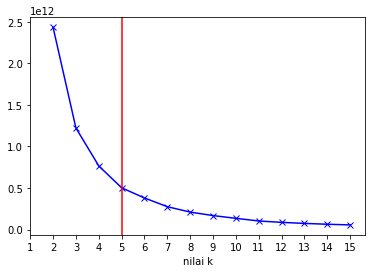

In [111]:
klaster = range(2, 16)
elbow = []

for k in klaster:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init=50)
    kmeans.fit(df_clustering)
    elbow.append(kmeans.inertia_)

k = KneeLocator(klaster, elbow, curve="convex", direction="decreasing").elbow

plt.plot(klaster, elbow, 'bx-')
plt.xlabel('nilai k')
plt.xticks(np.arange(1, 16, 1))
plt.axvline(x=k, color='red')
plt.show()

Menggunakan jumlah cluster sebanyak 5 sesuai dengan hasil Elbow Method

### Modeling

<b>Menggunakan algoritma KMeans dengan jumlah kluster sebanyak 5</b>

In [112]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=50)
kmeans.fit_predict(df_clustering, y=None)

data_clustering['Cluster'] = kmeans.labels_
data_clustering.head()

,NumberOfTransaction,Qty,TotalAmount,Gender,Marital Status,Income,Age,Cluster
CustomerID,,,,,,,,
1,17,60,623300,Laki-Laki,Married,5.120,55,1
2,13,57,392300,Laki-Laki,Married,6.230,60,2
3,15,56,446200,Laki-Laki,Married,9.170,32,4
4,10,46,302500,Laki-Laki,Married,4.870,31,3
5,7,27,268600,Laki-Laki,Married,3.570,58,3


<b>Melihat hasil kluster</b>

In [113]:
group_num = data_clustering.groupby('Cluster').agg({'NumberOfTransaction': 'count', 'Qty': 'mean', 'TotalAmount': 'mean', 'Income': 'mean', 'Age': 'mean'}).reset_index()
group_cat = data_clustering.groupby('Cluster')[['Gender', 'Marital Status']].apply(lambda x: x.mode().iloc[0]).reset_index()

pd.merge(group_num, group_cat, on='Cluster').set_index('Cluster')

,NumberOfTransaction,Qty,TotalAmount,Income,Age,Gender,Marital Status
Cluster,,,,,,,
0,73,23.726,191141.096,8.724,37.507,Wanita,Married
1,38,62.816,611818.421,7.744,38.711,Wanita,Married
2,124,42.508,381419.355,8.330,41.323,Wanita,Married
3,127,34.843,288907.087,8.801,40.441,Wanita,Married
4,82,52.561,480232.927,9.050,39.268,Laki-Laki,Married


### Kesimpulan

- Cluster 0 => Customer yang berbelanja di toko dengan harga produk yang paling murah dan dengan jumlah belanja yang paling sedikit
- Cluster 1 => Customer yang berbelanja di toko dengan harga produk yang paling mahal dan dengan jumlah belanja yang paling banyak
- Cluster 2 => Customer yang berbelanja di toko dengan harga produk yang sedikit mahal dan dengan jumlah belanja yang lumayan banyak
- Cluster 3 => Customer yang berbelanja di toko dengan harga produk yang lumayan murah dan dengan jumlah belanja yang lumayan sedikit
- Cluster 4 => Customer yang berbelanja di toko dengan harga produk yang lumayan mahal dan dengan jumlah belanja yang banyak

Rata-rata customer adalah wanita dengan status sudah menikah yang berada pada umur 37 hingga 42 tahun yang memiliki income 7 hingga 9